In [15]:
%reload_ext autoreload
%autoreload 2

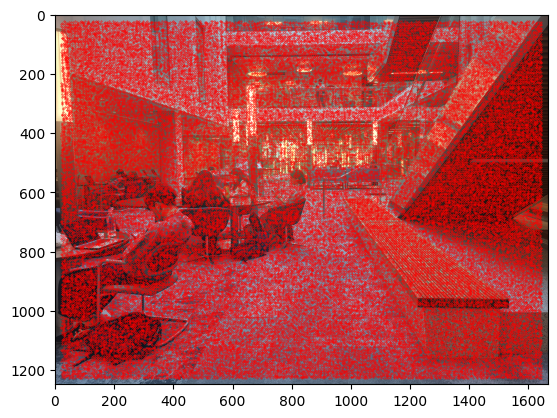

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from harris import get_harris_corners, dist2
from utils import show_image

img = plt.imread('data/bww31.jpg')

h, corners = get_harris_corners(img.mean(axis=2)) # 2 x [x, y]
plt.imshow(img, cmap='gray')
plt.scatter(corners[1], corners[0], s=0.1, c='r')
plt.savefig('out/bww31_harris.png', dpi=300)
plt.show()

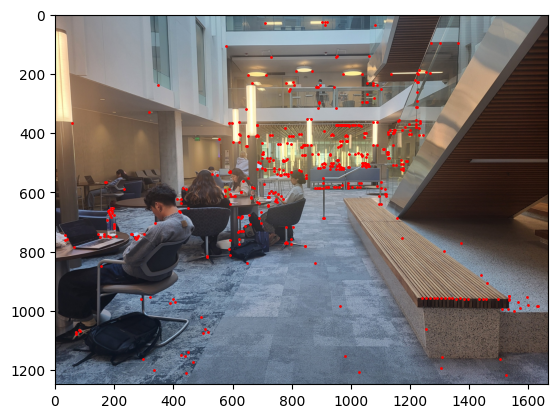

In [17]:
def anms(h, corners, n):
    avg = np.mean(h[corners[0], corners[1]])
    corners = corners[:, h[corners[0], corners[1]] > avg]
    dists = dist2(corners.T, corners.T)
    radii = np.full(corners.shape[1], np.inf)
    h_vals = h[corners[0], corners[1]]
    for i in range(corners.shape[1]):
        stronger = np.where(h_vals > h_vals[i] * 0.9)[0]
        if stronger.size == 0:
            continue
        radii[i] = dists[i, stronger].min()
    order = np.argsort(-radii)
    return corners[:, order[:n]]

anms_corners = anms(h, corners, 500)
plt.imshow(img, cmap='gray')
plt.scatter(anms_corners[1], anms_corners[0], s=1, c='r')
plt.savefig('out/bww31_anms.png', dpi=300)
plt.show()

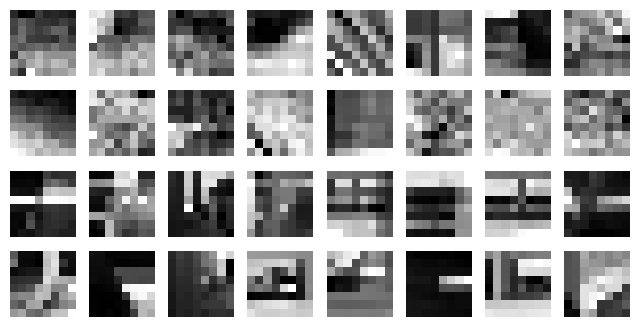

In [18]:
import cv2

def feature_description(img, corners, desc_rad=20):
    descs = []
    # blur image to reduce noise effects
    img = cv2.GaussianBlur(img, (5, 5), 1.0)
    # no need for padding because we avoid edges in corners
    for i in range(corners.shape[1]):
        y, x = corners[:, i]
        patch = img[y - desc_rad:y + desc_rad, x - desc_rad:x + desc_rad + 1]

        if img.ndim == 3:
            patch = patch.mean(axis=2)

        patch = cv2.resize(patch, (8, 8))

        patch = (patch - patch.mean()) / (patch.std() + 1e-10)
        descs.append(patch.flatten())
    return np.array(descs)

descs = feature_description(img, anms_corners)
fig, axes = plt.subplots(4, 8, figsize=(8, 4))
for i in range(32):
    ax = axes[i // 8, i % 8]
    desc_img = descs[i].reshape((8, 8))
    desc_img = (desc_img - desc_img.min()) / (desc_img.max() - desc_img.min())
    ax.imshow(desc_img, cmap='gray')
    ax.axis('off')
plt.savefig('out/bww31_feature_descriptions.png', dpi=300)


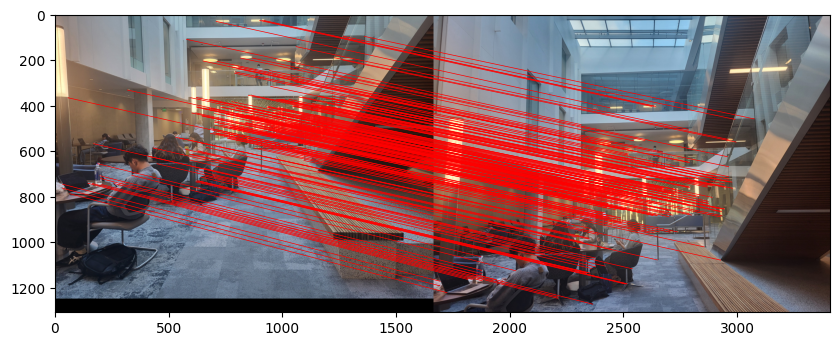

In [19]:
def match_features(descs1, descs2, ratio_thresh=0.5):
    matches = []
    dists = dist2(descs1, descs2)
    for i in range(descs1.shape[0]):
        partitioned = np.partition(dists[i], 2)
        if partitioned[0] < ratio_thresh * partitioned[1]:
            matches.append((i, np.where(dists[i] == partitioned[0])[0][0]))
    return np.array(matches)

img1 = plt.imread('data/bww31.jpg')
img2 = plt.imread('data/bww32.jpg')
h1, corners1 = get_harris_corners(img1.mean(axis=2))
anms_corners1 = anms(h1, corners1, 500)
descs1 = feature_description(img1, anms_corners1)
h2, corners2 = get_harris_corners(img2.mean(axis=2))
anms_corners2 = anms(h2, corners2, 500)
descs2 = feature_description(img2, anms_corners2)
matches = match_features(descs1, descs2)
def show_matches(img1, img2, corners1, corners2, matches):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    out_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    out_img[:h1, :w1] = img1
    out_img[:h2, w1:w1 + w2] = img2

    plt.imshow(out_img)
    for match in matches:
        y1, x1 = corners1[:, match[0]]
        y2, x2 = corners2[:, match[1]]
        plt.plot([x1, x2 + w1], [y1, y2], 'r-', linewidth=0.5)
    plt.savefig('out/bww31_bww32_matches.png', dpi=300)
    plt.show()

plt.figure(figsize=(10, 5))
show_matches(img1, img2, anms_corners1, anms_corners2, matches)

In [26]:
# From part 1

def computeH(im1_pts, im2_pts):
    n = len(im1_pts)
    A = np.zeros((2 * n, 8))
    b = np.zeros((2 * n, 1))

    for i in range(n):
        x, y = im1_pts[i]
        xp, yp = im2_pts[i]
        A[2*i]   = [x, y, 1, 0, 0, 0, -x*xp, -y*xp]
        A[2*i+1] = [0, 0, 0, x, y, 1, -x*yp, -y*yp]
        b[2*i]   = xp
        b[2*i+1] = yp

    # Solve Ah = b via least squares
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    h = np.append(h, 1)
    H = h.reshape(3, 3)
    return H

def warpImageBilinear(im, H, output_shape=None, fill=0):
    h, w = im.shape[:2]
    if output_shape is None:
        out_h, out_w = h, w
    else:
        out_h, out_w = output_shape

    Hinv = np.linalg.inv(H)
    xs = np.arange(out_w)
    ys = np.arange(out_h)
    xs_grid, ys_grid = np.meshgrid(xs, ys, indexing='xy')
    pts = np.stack([xs_grid.ravel(), ys_grid.ravel(), np.ones(xs_grid.size)], axis=0)
    src = Hinv @ pts
    src /= src[2:3, :]

    x_src = src[0, :]
    y_src = src[1, :]

    # floor and clamped ceil (clamp so border pixels are handled)
    x0 = np.floor(x_src).astype(int)
    y0 = np.floor(y_src).astype(int)
    x1 = np.minimum(x0 + 1, w - 1)
    y1 = np.minimum(y0 + 1, h - 1)

    # valid if top-left is inside image bounds
    valid = (x0 >= 0) & (y0 >= 0) & (x0 < w) & (y0 < h)

    dx = x_src - x0  # fractional part in x
    dy = y_src - y0  # fractional part in y

    im_float = im.astype(np.float64)

    if im.ndim == 3:
        out = np.full((out_h * out_w, im.shape[2]), fill, dtype=np.float64)
        for c in range(im.shape[2]):
            channel = im_float[..., c]
            Ia = channel[y0[valid], x0[valid]]  # top-left
            Ib = channel[y0[valid], x1[valid]]  # top-right (clamped)
            Ic = channel[y1[valid], x0[valid]]  # bottom-left
            Id = channel[y1[valid], x1[valid]]  # bottom-right
            wx = dx[valid]
            wy = dy[valid]
            vals = (1 - wx) * (1 - wy) * Ia + \
                   wx * (1 - wy) * Ib + \
                   (1 - wx) * wy * Ic + \
                   wx * wy * Id
            out[valid, c] = vals
        out_img = out.reshape((out_h, out_w, im.shape[2]))
        # cast back to original dtype (with clipping for integer types)
        if np.issubdtype(im.dtype, np.integer):
            info = np.iinfo(im.dtype)
            out_img = np.clip(out_img, info.min, info.max).astype(im.dtype)
        else:
            out_img = out_img.astype(im.dtype)
        return out_img
    else:
        out = np.full((out_h * out_w,), fill, dtype=np.float64)
        channel = im_float
        Ia = channel[y0[valid], x0[valid]]
        Ib = channel[y0[valid], x1[valid]]
        Ic = channel[y1[valid], x0[valid]]
        Id = channel[y1[valid], x1[valid]]
        wx = dx[valid]
        wy = dy[valid]
        vals = (1 - wx) * (1 - wy) * Ia + \
               wx * (1 - wy) * Ib + \
               (1 - wx) * wy * Ic + \
               wx * wy * Id
        out[valid] = vals
        out_img = out.reshape((out_h, out_w))
        if np.issubdtype(im.dtype, np.integer):
            info = np.iinfo(im.dtype)
            out_img = np.clip(out_img, info.min, info.max).astype(im.dtype)
        else:
            out_img = out_img.astype(im.dtype)
        return out_img


def mosaic(ims, homographies, reference_index=0):
    """
    Build a mosaic from a list of images 'ims' and a list of adjacent homographies
    'homographies' where homographies[i] = H_i_to_{i+1}
    Returns the stitched RGB (or grayscale) image with simple overwriting (keeps behavior close to original).
    """
    n = len(ims)
    assert len(homographies) == n - 1, "homographies must be length n-1 and correspond to adjacent pairs"

    # Hs[i] maps image i -> reference coordinates
    Hs = [np.eye(3) for _ in range(n)]
    for i in range(reference_index - 1, -1, -1):
        Hs[i] = Hs[i + 1] @ homographies[i]

    # Propagate right from reference (images with index > reference_index)
    for i in range(reference_index, n - 1):
        Hs[i + 1] = Hs[i] @ np.linalg.inv(homographies[i])

    corners = []
    for i, im in enumerate(ims):
        h, w = im.shape[:2]
        corner_pts = np.array([[0, 0, 1], [w - 1, 0, 1], [0, h - 1, 1], [w - 1, h - 1, 1]]).T  # pixel corners
        transformed = Hs[i] @ corner_pts
        transformed /= transformed[2, :]
        corners.append(transformed[:2, :])
    corners = np.hstack(corners)  # 2 x (4*n)
    min_xy = np.floor(corners.min(axis=1)).astype(int)
    max_xy = np.ceil(corners.max(axis=1)).astype(int)
    min_x, min_y = int(min_xy[0]), int(min_xy[1])
    max_x, max_y = int(max_xy[0]), int(max_xy[1])

    # +1 to include the last coordinate properly
    canvas_w = max_x - min_x + 1
    canvas_h = max_y - min_y + 1
    output_shape = (canvas_h, canvas_w, ims[0].shape[2]) if ims[0].ndim == 3 else (canvas_h, canvas_w)

    # Translation offset: maps reference coords -> canvas coords
    offset = np.array([[1, 0, -min_x],
                       [0, 1, -min_y],
                       [0, 0, 1]], dtype=np.float64)

    # Initialize canvas
    is_color = ims[0].ndim == 3
    out = np.zeros(output_shape, dtype=np.float64)
    # Track which pixels have content (binary mask)
    canvas_mask = np.zeros((canvas_h, canvas_w), dtype=bool)

    for i, im in enumerate(ims):
        h, w = im.shape[:2]
        H_canvas = offset @ Hs[i]
        
        # Create distance-based weight map that stays at 1.0 until near edges
        y_coords = np.arange(h)
        x_coords = np.arange(w)
        y_grid, x_grid = np.meshgrid(y_coords, x_coords, indexing='ij')
        
        # Distance to nearest edge (min of distances to all 4 edges)
        dist_to_edge = np.minimum(
            np.minimum(x_grid + 1, w - x_grid),
            np.minimum(y_grid + 1, h - y_grid)
        ).astype(np.float64)
        
        feather_width = 50  # pixels of falloff at edge
        alpha_map = np.clip(dist_to_edge / feather_width, 0, 1)
        
        # Warp the image
        warped = warpImageBilinear(im.astype(np.float64), H_canvas, 
                                   output_shape=output_shape[:2], fill=0)
        
        # Warp the alpha/weight map
        warped_alpha = warpImageBilinear(alpha_map, H_canvas, 
                                        output_shape=output_shape[:2], fill=0)
        
        # Create mask for current warped image (non-zero pixels)
        if is_color:
            warped_mask = (warped.sum(axis=2) > 0)
        else:
            warped_mask = (warped > 0)
        # Overlap region: where both canvas and new image have content
        overlap = canvas_mask & warped_mask
        # In overlap regions, use feathered alpha; elsewhere use full replacement
        effective_alpha = np.where(overlap, warped_alpha, 1.0)
        effective_alpha = effective_alpha[warped_mask]
        # Blend: where effective_alpha=1, fully replace; where <1, blend
        if is_color:
            for c in range(ims[0].shape[2]):
                out[warped_mask, c] = warped[warped_mask, c] * effective_alpha + out[warped_mask, c] * (1 - effective_alpha)
        else:
            out = warped * effective_alpha + out * (1 - effective_alpha)
        info = np.iinfo(ims[0].dtype)

        # Update canvas mask with new content
        canvas_mask |= warped_mask
    
    # Convert back to original dtype
    if np.issubdtype(ims[0].dtype, np.integer):
        info = np.iinfo(ims[0].dtype)
        out = np.clip(out, info.min, info.max).astype(ims[0].dtype)
    else:
        out = out.astype(ims[0].dtype)
    return out

In [27]:
# RANSAC for homography estimation
def ransac_homography(corners1, corners2, matches):
    max_inliers = []
    best_H = None
    num_iters = 1000
    inlier_thresh = 5.0

    for _ in range(num_iters):
        sampled_matches = matches[np.random.choice(matches.shape[0], 4, replace=False)]
        pts1 = np.array([corners1[:, m[0]] for m in sampled_matches])
        pts2 = np.array([corners2[:, m[1]] for m in sampled_matches])

        H = computeH(pts1[:, ::-1], pts2[:, ::-1])

        inliers = []
        for m in matches:
            pt1 = np.array([corners1[1, m[0]], corners1[0, m[0]], 1])
            pt2 = np.array([corners2[1, m[1]], corners2[0, m[1]], 1])

            projected_pt1 = H @ pt1
            projected_pt1 /= projected_pt1[2]

            error = np.linalg.norm(projected_pt1[:2] - pt2[:2])
            if error < inlier_thresh:
                inliers.append(m)

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_H = H

    return best_H, np.array(max_inliers)

def auto_mosaic(ims, reference_index=0):
    homographies = []
    for i in range(len(ims) - 1):
        img1 = ims[i]
        img2 = ims[i + 1]
        h1, corners1 = get_harris_corners(img1.mean(axis=2))
        anms_corners1 = anms(h1, corners1, 500)
        descs1 = feature_description(img1, anms_corners1)
        h2, corners2 = get_harris_corners(img2.mean(axis=2))
        anms_corners2 = anms(h2, corners2, 500)
        descs2 = feature_description(img2, anms_corners2)
        matches = match_features(descs1, descs2)
        H, inliers = ransac_homography(anms_corners1, anms_corners2, matches)
        homographies.append(H)
    mosaic_img = mosaic(ims, homographies, reference_index=reference_index)
    return mosaic_img

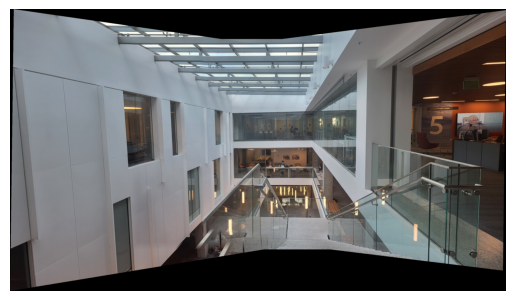

In [28]:
im1 = plt.imread("data/bair53.jpg")
im2 = plt.imread("data/bair52.jpg")
im3 = plt.imread("data/bair51.jpg")
im_list = [im1, im2, im3]

mosaic_img = auto_mosaic(im_list, reference_index=1)
show_image(mosaic_img, "out/bair5_mosaic_auto.jpg")

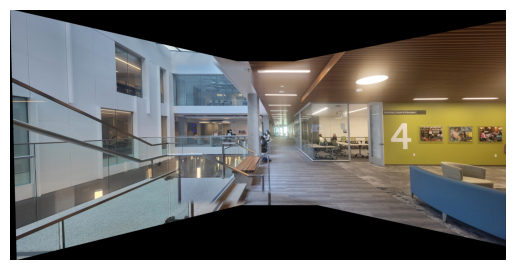

In [29]:
im1 = plt.imread("data/bww41.jpg")
im2 = plt.imread("data/bww42.jpg")
im3 = plt.imread("data/bww43.jpg")
im_list = [ im1, im2, im3]

mosaic_img = auto_mosaic(im_list, reference_index=1)
show_image(mosaic_img, "out/bww4_mosaic_auto.jpg")

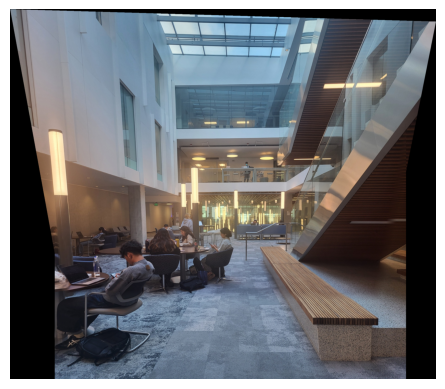

In [30]:
im1 = plt.imread("data/bww31.jpg")
im2 = plt.imread("data/bww32.jpg")
im_list = [im1, im2]

mosaic_img = auto_mosaic(im_list)
show_image(mosaic_img, "out/bww3_mosaic_auto.jpg")

In [31]:
# convert out/bww4_feather1.png and out/bww4_feather2.png to jpg for submission
from PIL import Image
img = Image.open("out/bww4_feather1.png")
rgb_img = img.convert('RGB')
rgb_img.save("out/bww4_feather1.jpg")

img = Image.open("out/bww4_feather2.png")
rgb_img = img.convert('RGB')
rgb_img.save("out/bww4_feather2.jpg")

# also bww4_step1.png, step2, step3
img = Image.open("out/bww4_step1.png")
rgb_img = img.convert('RGB')
rgb_img.save("out/bww4_step1.jpg")

img = Image.open("out/bww4_step2.png")
rgb_img = img.convert('RGB')
rgb_img.save("out/bww4_step2.jpg")

img = Image.open("out/bww4_step3.png")
rgb_img = img.convert('RGB')
rgb_img.save("out/bww4_step3.jpg")
